# Reprotrack - Replicate tracking quality assessment

Depending on the tracking device and the environment (e.g., urban canyons), the tracking quality represented in terms of temporal tracking coverage can vary significantly. With fewer gaps in a tracking study, we can analyze the behavior of study participants with less uncertainty. It is therefore important to analyze and report the temporal tracking coverage of a dataset. However, the temporal tracking coverage depends strongly on the definition of what constitutes a _gap_ in the tracking data (e.g., 15 minutes of missing data, 1 day of missing data, ...).

In this exercise, you should replicate the results of the tracking coverage analysis shown below and get a feeling of the parameters that influence them. 

#### Temporal tracking coverage (overall)
<img src="../Data/interactive1_overall.png" alt="hierarchy" width="400"/>

#### Temporal tracking coverage (by month)
<img src="../Data/interactive1_bymonth.png" alt="hierarchy" width="400"/>

#### Temporal tracking coverage (by day)
<img src="../Data/interactive1_byday.png" alt="hierarchy" width="400"/>

#### Temporal tracking coverage (by weekday)
<img src="../Data/interactive1_byweekday.png" alt="hierarchy" width="400"/>

#### Temporal tracking coverage (by hour of day)
<img src="../Data/interactive1_byhourofday.png" alt="hierarchy" width="400"/>

# Import dependencies and libraries

In [1]:
import os
import json
import pickle as pickle

import geopandas as gpd
import pandas as pd
import numpy as np

# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# trackintel -> the functions will be imported with full names
import trackintel as ti


In [2]:
# options for better printing and visualizing

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [3]:
# get the data dir from the config file -> default stored in Data/Geolife/Data folder

DATA_DIR = os.path.join("..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", CONFIG["data_dir"])

# Load and preprocess Geolife data (skip if you want to use your own data)
Trackintel provides a function [read_geolife](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_geolife) to directly load [Geolife](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) dataset into the trackintel positionfixes. For the tutorial and interactive section, we provided you a sample dataset with 20 selected users from the geolife dataset. This can be directly loaded from the `save_dir`.

In [4]:
pfs, mode_labels = ti.io.read_geolife(save_dir, print_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


## Generate staypoints and triplegs 
Select the temporal parameters to reflect your design choice of a `time gap`. 

Tasks: 
- create staypoints [[documentation](https://trackintel.readthedocs.io/en/latest/modules/preprocessing.html#trackintel.preprocessing.generate_staypoints)]: a staypoint is created when a person does not move outside of a specific area (_dist\_threshold_ in meter) for a specific time (_time\_threshold_ in minutes). However, it is important to quantify how long a gap between two consecutive trackpoints can be without resetting the search for a staypoint (e.g., is 1 single trackpoint per day enough to conclude that a person stayed at the same location during the day?). This threshold can be changed using the _gap\_threshold_ parameter (in minutes). For the images above the value `24*60` was used.
- create triplegs [[documentation](https://trackintel.readthedocs.io/en/latest/modules/preprocessing.html#trackintel.preprocessing.generate_triplegs)]: a tripleg (using the sliding method) is created by assigning all positionfixes that lie in between staypoints to triplegs. However, similar to staypoints two consecutive positionfixes can have a gap and we have to decide what time is acceptable. This threshold can be changed using the _gap\_threshold_ parameter (in minutes). For the images above the value `15` was used.
- concatenate staypoints and triplegs into a single dataframe to obtain a continuous timeline for measuring the tracking coverage.

The goal now is to prepare the data (following the steps above), calculate the temporal tracking coverage on different granularities (more information below), and then vary the parameters to see the effect on the results.  

In [5]:
# generate staypoints, triplegs
pfs, sp = pfs.generate_staypoints() ### adjust parameters of `generate_staypoints`

C:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


In [6]:
# generate triplegs
pfs, tpls = pfs.generate_triplegs() ### adjust parameters of `generate_triplegs`

C:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [ 641251  641252 1194474 1194475] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


In [7]:
# merge triplegs and staypoints
df_all = pd.concat([sp, tpls])

### Overall quality
Trackintel provides the [trackintel.analysis.temporal_tracking_quality](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#trackintel.analysis.temporal_tracking_quality) function to measure the temporal tracking coverage. For the function to work, users need to specify a temporal `granularity`. Check the documentations and decide on a desired granularity.

In [8]:
# get quality
total_quality = ti.analysis.temporal_tracking_quality() ### adjust parameters of `temporal_tracking_quality`

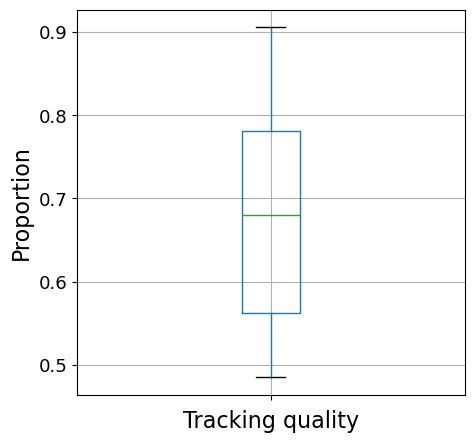

In [9]:
boxplot = total_quality.boxplot(column="quality", figsize=(5, 5))

boxplot.set_xticklabels([])

plt.xlabel("Tracking quality", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
plt.savefig("../Data/interactive1_overall.png")
plt.show()

### Quality by week

In [10]:
# get quality
week_quality = ti.analysis.temporal_tracking_quality() ### adjust parameters of `temporal_tracking_quality`

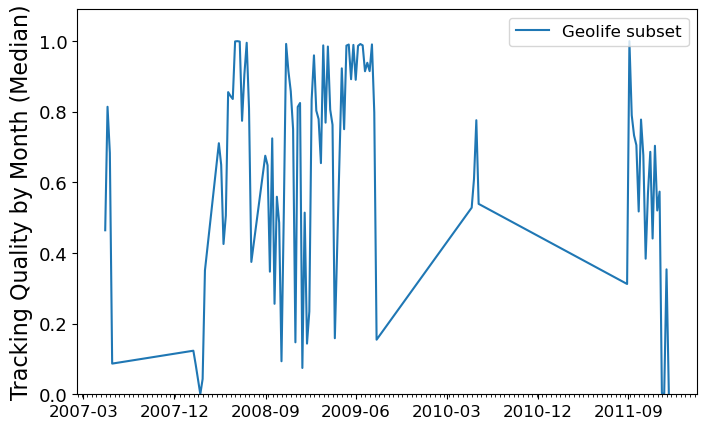

In [11]:
# preprocessing and plotting
week_quality_user = week_quality.loc[week_quality["quality"] != 0].groupby("week_monday", as_index=False)["quality"].median()
# construct the index
week_quality_user.set_index("week_monday",inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(week_quality_user.index, week_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Month (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')
plt.savefig("../Data/interactive1_bymonth")
plt.show()


### Quality by day

In [12]:
# get quality
day_quality = ti.analysis.temporal_tracking_quality() ### adjust parameters of `temporal_tracking_quality`

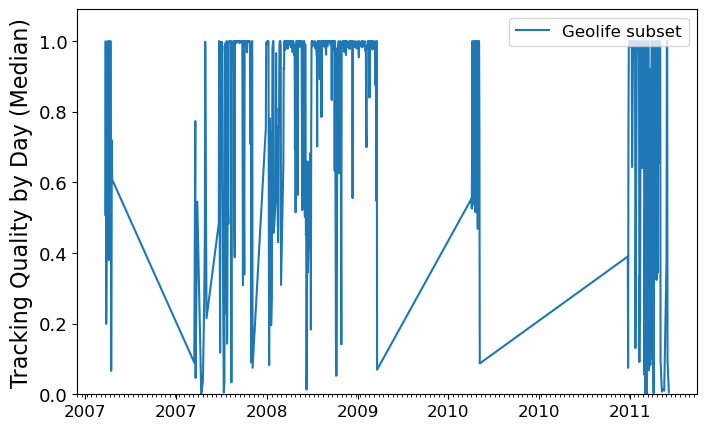

In [13]:
# preprocessing and plotting
day_quality_user = day_quality.loc[day_quality["quality"] != 0].groupby("day", as_index=False)["quality"].median()

# construct the index
day_quality_user.set_index("day",inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(day_quality_user.index, day_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Day (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')
plt.savefig("../Data/interactive1_byday")
plt.show()


### Quality by weekday

In [14]:
# get quality
weekday_quality = ti.analysis.temporal_tracking_quality() ### adjust parameters of `temporal_tracking_quality`

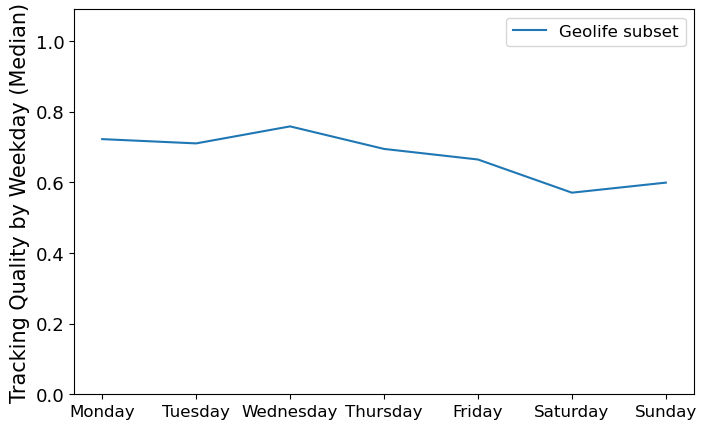

In [15]:
weekday_quality_user = weekday_quality.loc[weekday_quality["quality"] != 0].groupby("weekday", as_index=False)["quality"].median()
weekday_quality_user.set_index("weekday",inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(weekday_quality_user.index, weekday_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Weekday (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(7), labels= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax.legend(prop={'size': 12}, loc = 'upper right')
plt.savefig("../Data/interactive1_byweekday")
plt.show()


### Quality by hour

In [ ]:
# get quality
hour_quality = ti.analysis.temporal_tracking_quality() ### adjust parameters of `temporal_tracking_quality`

In [ ]:
hour_quality_user = hour_quality.loc[hour_quality["quality"] != 0].groupby("hour", as_index=False)["quality"].median()
hour_quality_user.set_index("hour",inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hour_quality_user.index, hour_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Hour (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of the day", fontsize=15)

ax.legend(prop={'size': 12}, loc = 'upper right')
plt.savefig("../Data/interactive1_byhourofday")
plt.show()